In [110]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pathlib import Path

# %matplotlib widget
# plt.style.use("seaborn")
# plt.rcParams["figure.constrained_layout.use"] = True
# plt.rcParams["axes.grid"] = True

## Big range plot

In [218]:
all_data = []

dirs = list(Path("data").glob("[!T.]*"))
dirs.sort()
for in_dir in dirs:
    files = list(in_dir.glob("*.csv"))
    files.sort()

    rms_in_arr = []
    rms_out_arr = []
    freq_arr = []
    res_arr = []

    for file in files:
        freq = float(file.stem.split("_")[1])
        data = np.loadtxt(file, delimiter=",")

        rms_out, rms_in = np.sqrt((data**2).mean(axis=0))
        # res = 20 * np.log10(1 - rms_out / rms_in)
        res = 1e3 * (rms_in / rms_out - 1)

        freq_arr.append(freq)
        rms_in_arr.append(rms_in)
        rms_out_arr.append(rms_out)
        res_arr.append(res)
    
    res_arr = np.array(res_arr)
    freq_arr = np.array(freq_arr)
    
    all_data.append([freq_arr, res_arr])

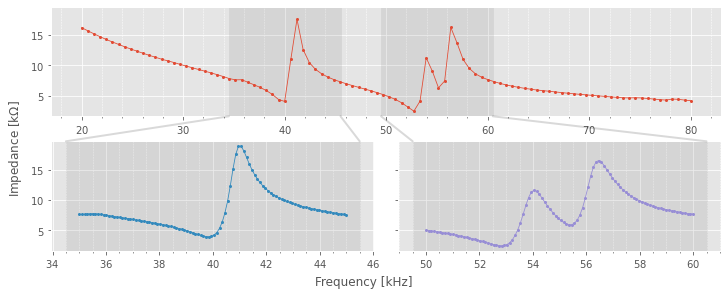

In [231]:
from matplotlib.patches import ConnectionPatch
from matplotlib.transforms import blended_transform_factory
from typing import Dict

(freq1, res1), (freq2, res2), (freq3, res3) = all_data

axd: Dict[str, plt.Axes]
fig, axd = plt.subplot_mosaic([['top', 'top'], ['left', 'right']], sharey=True, figsize=(10,4))

axd["top"].plot  (freq1/1000, res1/1000, marker="o", c="C0", markersize=2)
axd["left"].plot (freq2/1000, res2/1000, marker="o", c="C1", markersize=2)
axd["right"].plot(freq3/1000, res3/1000, marker="o", c="C2", markersize=2)

for k, v in axd.items():
    v.grid(True, "minor", ls="--", lw=0.5)
    v.xaxis.set_minor_locator(plt.MultipleLocator(
        2 if k == "top" else 0.5
    ))

trans = {k: blended_transform_factory(v.transData, v.transAxes) for k, v in axd.items()}
for i, k in [[1, "left"], [2, "right"]]:
    l1, l2 = axd[k].get_xlim()
    # l1 = np.ceil(l1 / 2) * 2
    # l2 = np.floor(l2 / 2) * 2
    axd["top"].axvspan(l1, l2, color="gray", alpha=0.15)
    axd[k].axvspan(l1, l2, color="gray", alpha=0.15)
    for l in [l1, l2]:
        con = ConnectionPatch(xyA=(l, 0), xyB=(l, 1),
                              coordsA=trans["top"], coordsB=trans[k],
                             axesA=axd["top"], axesB=axd[k], lw=2,
                             color="black", alpha=0.15)
        con.set_in_layout(False)
        fig.add_artist(con)

fig.supxlabel(r"Frequency [kHz]")
fig.supylabel(r"Impedance [k$\Omega$]")

fig.savefig("plots/frekvenskare.pdf")

## Transducer comparison

In [227]:
ress = []
freqs = []

dirs = list(Path("data").glob("T*P1"))
dirs.sort()
for idx, in_dir in enumerate(dirs):
    print(in_dir)
    out_path = Path("plots", in_dir.stem + ".pdf")
    files = list(in_dir.glob("*.csv"))
    files.sort()

    rms_in_arr = []
    rms_out_arr = []
    freq_arr = []
    res_arr = []

    for file in files:
        freq = float(file.stem.split("_")[1])
        data = np.loadtxt(file, delimiter=",")

        rms_out, rms_in = np.sqrt((data**2).mean(axis=0))
        # res = 20 * np.log10(rms_out / rms_in)
        res = 1e3 * (rms_in / rms_out - 1)

        freq_arr.append(freq)
        rms_in_arr.append(rms_in)
        rms_out_arr.append(rms_out)
        res_arr.append(res)
    
    ress.append(np.array(res_arr))
    freqs.append(np.array(freq_arr))

data/T1P1
data/T2P1
data/T3P1
data/T4P1


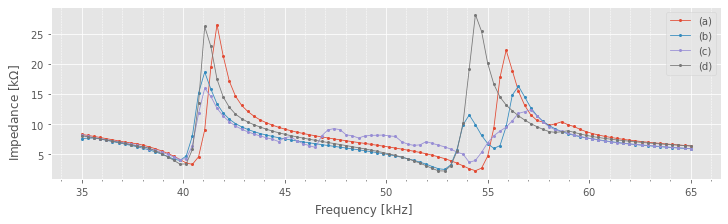

In [230]:
plt.close("all")
fig, ax = plt.subplots(1, 1)

for idx, (freq_arr, res_arr) in enumerate(zip(freqs, ress)):
    ax.plot(freq_arr/1000, res_arr/1000, marker="o", c=f"C{idx}", label=f"({chr(ord('`')+idx+1)})", markersize=2)
ax.grid(True, "minor", ls="--", lw=0.5)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.legend()

fig.supylabel(r"Impedance [k$\Omega$]")
fig.supxlabel(r"Frequency [kHz]")

out_path.parent.mkdir(exist_ok=True, parents=True)
plt.show()
fig.savefig("plots/sammenligning.pdf")

## Distortion

In [52]:
in_path = Path("data/20k_to_80k")
files = list(in_path.glob("*.csv"))
files.sort()
wfd = dict()
for file in files:
    data = np.loadtxt(file, delimiter=",")
    freq = float(file.stem.split("_")[1])
    
    signs = np.sign(data)
    edges = (signs[1:] * signs[:-1]) == -1
    
    crossings_in,  = np.nonzero(edges[:,1])
    crossings_out, = np.nonzero(edges[:,0])
    
    minidx_in  = abs(data[:,1][crossings_in]).argmin()
    minidx_out = abs(data[:,0][crossings_out]).argmin()
    
    wf_in  = data[crossings_in[minidx_in-1]:crossings_in[minidx_in+1]+1,1]
    wf_out = data[crossings_out[minidx_out-1]:crossings_out[minidx_out+1]+1,0]
    
    wfd[freq] = {"in": wf_in, "out": wf_out}
# display(wfd)

/tmp/ipykernel_13493/3297525084.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(cmap, ax=list(axd.values()), ticks=np.linspace(0, 100, 5))


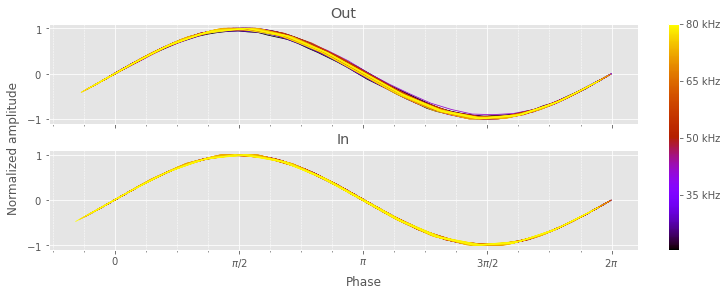

In [165]:
fig, axd = plt.subplot_mosaic([["top"], ["bottom"]], figsize=(10, 4), sharex=True, sharey=True)

c = np.arange(1, len(wfd)+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.gnuplot)
cmap.set_array([])

for i, (k, v) in enumerate(wfd.items()):
    wfin, wfout = v.values()
    if len(wfout) == 0 or len(wfin) == 0:
        continue
    
    # Fix sign
    if wfin[0] > 0:
        wfin = -wfin
    if wfout[0] > 0:
        wfout = -wfout
        
    # Normalize
    wfin /= max(abs(wfin))
    wfout /= max(abs(wfout))
    
    # Calculate phase offsets
    offsetinl  = np.arcsin(wfin[0]   )# / (2 * np.pi)
    offsetoutl = np.arcsin(wfout[0] )# / (2 * np.pi)
    offsetinr  = np.arcsin(wfin[-1]  )# / (2 * np.pi)
    offsetoutr = np.arcsin(wfout[-1])
    
    # Generate X axes data to align phases
    xin = np.linspace(offsetinl, 2*np.pi+offsetinr, len(wfin))
    xout = np.linspace(offsetoutl, 2*np.pi+offsetoutr, len(wfout))
    
    # Plot data
    axd["top"].plot(xout, wfout, c=cmap.to_rgba(i+1))
    axd["bottom"].plot(xin, wfin, c=cmap.to_rgba(i+1))


axd["bottom"].set_xticks(np.linspace(0, 2*np.pi, 5))
axd["bottom"].set_xticklabels([0, r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])

for k, v in axd.items():
    v.grid(True, "minor", ls="--", lw=0.5)
    v.xaxis.set_minor_locator(plt.MultipleLocator(np.pi/8))

axd["top"].set_title("Out")
axd["bottom"].set_title("In")
fig.supxlabel("Phase")
fig.supylabel("Normalized amplitude")
cbar = fig.colorbar(cmap, ax=list(axd.values()), ticks=np.linspace(0, 100, 5))
cbar.ax.set_yticklabels([f"{x:.0f} kHz" for x in np.linspace(20, 80, 5)]);

fig.savefig("plots/distortion.pdf")